In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd

import random
import copy
import os
from astropy.io import fits

import lenstronomy.Util.util as util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot

if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
def plot_image(image):
    plt.figure(figsize=(12,4)) 
    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    plt.imshow(rgb, aspect='equal')
    plt.axis('off')
    plt.show()
    
def plot_modeling(image, modelPlot):
    f, axes = plt.subplots(1, 4, figsize=(16, 8), sharex=False, sharey=False)

    image = np.flip(image, 1)
    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    axes[0].imshow(rgb, aspect='equal')
    axes[0].axis('off')

    modelPlot.data_plot(ax=axes[1])
    modelPlot.model_plot(ax=axes[2])
    modelPlot.normalized_residual_plot(ax=axes[3], v_min=-6, v_max=6)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    
    plt.show()

In [3]:
filepath = 'data_simulations.fits'
hdu_list = fits.open(filepath)
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()

In [4]:
# Data Specifics
background_rms = 7.  #  background noise per pixel 
exp_time = 90.  #  exposure time 
numPix = 45  #  cutout pixel size per axis
deltaPix = 0.2637  #  pixel size in arcsec
fwhm = 1.#0.05
psf_type = 'GAUSSIAN' 

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, 
                                    deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }
data_class = ImageData(**kwargs_data)

# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)

In [5]:
def Modeling(kwargs_model, image, params_init):
    
    kwargs_data_g = copy.deepcopy(kwargs_data)
    kwargs_data_i = copy.deepcopy(kwargs_data)
    kwargs_data_r = copy.deepcopy(kwargs_data)
    kwargs_data_g['image_data'] = image[0]
    kwargs_data_r['image_data'] = image[1]
    kwargs_data_i['image_data'] = image[2]
    
    # lens models
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
    kwargs_lens_init.append(params_init['lens_init_mass'])
    kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.05, 'e2': 0.05,
                             'center_x': 0.05, 'center_y': 0.05})
    kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_lens.append({'theta_E': 10., 'e1': 0.5, 'e2': 0.5, 'center_x': 2, 'center_y': 2})

    fixed_lens.append({'ra_0': 0, 'dec_0': 0})
    kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
    kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []


    fixed_source.append({})
    kwargs_source_init.append(params_init['source_init'])
    kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2})
    kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -5, 'center_y': -5})
    kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 5, 'center_y': 5})

    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []


    fixed_lens_light.append({})
    kwargs_lens_light_init.append(params_init['lens_init_light'])
    kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 2, 'center_y': 2})

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

    kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params}

    kwargs_likelihood = {'source_marg': False}
    #kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list}

    multi_band_list = [[kwargs_data_g, kwargs_psf, kwargs_numerics], [kwargs_data_r, kwargs_psf, kwargs_numerics],
                      [kwargs_data_i, kwargs_psf, kwargs_numerics]]
    # if you have multiple  bands to be modeled simultaneously, you can append them to the mutli_band_list
    kwargs_data_joint = {'multi_band_list': multi_band_list, 
                         'multi_band_type': 'multi-linear'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                        }
    kwargs_constraints = {}

    #from lenstronomy.Workflow.fitting_sequence import FittingSequence
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 15., 'n_particles': 300, 'n_iterations': 250}],
                       ['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': .1}]
        ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
    return(kwargs_result, modelPlot)


In [6]:
ind = 28
image = images[ind]
data_image = data.iloc[ind]

kwargs_model = {'lens_model_list': ['SIE', 'SHEAR'],  # list of lens models to be used
                    'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                'source_light_model_list': ['SERSIC_ELLIPSE'],  # list of extended source models to be used
                #'point_source_model_list': ['SOURCE_POSITION']  # list of point source models to be used
    }
lens_init_mass = {'theta_E': data_image['Einstein_rad']+0.3, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.}
lens_init_light = {'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}
source_init = {'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}
params_init = {'lens_init_mass': lens_init_mass, 'lens_init_light': lens_init_light, 'source_init': source_init}

kwargs_result, modelPlot = Modeling(kwargs_model, image, params_init)
print(kwargs_result)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.04192616723226592 reduced X^2 of best position
-126.82665587760442 logL
6050 effective number of data points
[{'theta_E': 6.527140154668317, 'e1': -0.24239902389470733, 'e2': -0.018239102889648723, 'center_x': -0.3742212838003, 'center_y': -1.8087275422692055}, {'gamma1': -0.19989172798133806, 'gamma2': -0.0044651310041357115, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 2.986450900919394, 'n_sersic': 4.18548807456025, 'e1': 0.4972727680294291, 'e2': -0.15686175375732575, 'center_x': -0.26212954652752896, 'center_y': -2.1396245895194625}] source result
[{'amp': 1, 'R_sersic': 8.218297112037236, 'n_sersic': 4.034226883210327, 'e1': 0.14790923131082306, 'e2': 0.028127759557689862, 'center_x': -0.019178532909549368, 'center_y': 0.01079515721026991}] lens light result
[] point source result
{} special param result
199.3851439952

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:10<00:00,  6.12it/s]

Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
130.99772381782532 time taken for MCMC sampling
-0.042115171632660216 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.043784204115320545
reduced chi^2 of data  1 =  0.040540031778568075
reduced chi^2 of data  2 =  0.04202127900409204
{'kwargs_lens': [{'theta_E': 6.509733985663906, 'e1': -0.2332262888300412, 'e2': -0.02506832728735704, 'center_x': -0.365989734407811, 'center_y': -1.7959955818591054}, {'gamma1': -0.193101882196192, 'gamma2': -0.016187268368207358, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 9.188405626028983, 'R_sersic': 2.954650730256585, 'n_sersic': 4.003806239863345, 'e1': 0.4911319653224939, 'e2': -0.15967481104656597, 'center_x': -0.2573043520006951, 'center_y': -2.1547822180298106}], 'kwargs_lens_light': [{'amp': 16.450571243689588, 'R_sersic': 8.294407256953901, 'n_sersic': 4.044643371660553, 'e1': 0.14934749602


/Users/jimenagonzalez/.local/lib/python3.7/site-packages/lenstronomy-1.9.1-py3.7.egg/lenstronomy/Plots/plot_util.py:218: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_heat").copy()
  cmap.set_bad(color='k', alpha=1.)
/Users/jimenagonzalez/.local/lib/python3.7/site-packages/lenstronomy-1.9.1-py3.7.egg/lenstronomy/Plots/plot_util.py:219: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_heat").copy()
  cmap.set_under('k')


/Users/jimenagonzalez/.local/lib/python3.7/site-packages/lenstronomy-1.9.1-py3.7.egg/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


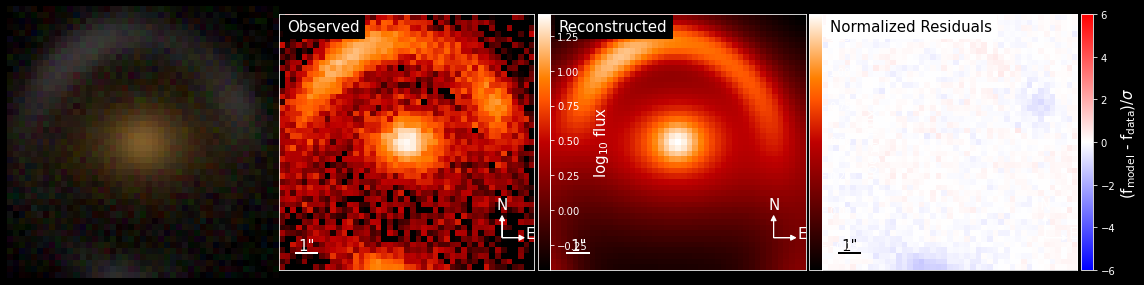

5.151546860940139
{'kwargs_lens': [{'theta_E': 6.509733985663906, 'e1': -0.2332262888300412, 'e2': -0.02506832728735704, 'center_x': -0.365989734407811, 'center_y': -1.7959955818591054}, {'gamma1': -0.193101882196192, 'gamma2': -0.016187268368207358, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 9.188405626028983, 'R_sersic': 2.954650730256585, 'n_sersic': 4.003806239863345, 'e1': 0.4911319653224939, 'e2': -0.15967481104656597, 'center_x': -0.2573043520006951, 'center_y': -2.1547822180298106}], 'kwargs_lens_light': [{'amp': 16.450571243689588, 'R_sersic': 8.294407256953901, 'n_sersic': 4.044643371660553, 'e1': 0.1493474960241888, 'e2': 0.012028991875341753, 'center_x': -0.026474232136078135, 'center_y': 0.0008388620447243728}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [7]:
plot_modeling(image, modelPlot)
print(data_image['Einstein_rad'])
print(kwargs_result)

In [8]:
results, plots = [], []
for i in range(len(data)):
    #if(i == 2): break
    image = images[i]
    data_image = data.iloc[i]

    kwargs_model = {'lens_model_list': ['SIE', 'SHEAR'],  # list of lens models to be used
                        'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                    'source_light_model_list': ['SERSIC_ELLIPSE'],  # list of extended source models to be used
                    #'point_source_model_list': ['SOURCE_POSITION']  # list of point source models to be used
        }
    lens_init_mass = {'theta_E': data_image['Einstein_rad']+0.4, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.}
    lens_init_light = {'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}
    source_init = {'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}
    params_init = {'lens_init_mass': lens_init_mass, 'lens_init_light': lens_init_light, 'source_init': source_init}

    kwargs_result, modelPlot = Modeling(kwargs_model, image, params_init)
    results.append(kwargs_result)
    plots.append(modelPlot)
    

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.4904857599737544 reduced X^2 of best position
-1483.719423920607 logL
6050 effective number of data points
[{'theta_E': 5.291802142494892, 'e1': 0.12581936045150807, 'e2': 0.19590670973377564, 'center_x': -0.7708430292958987, 'center_y': -0.27374410932912996}, {'gamma1': 0.1997100387166144, 'gamma2': 0.08510210257996585, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.7006095199660638, 'n_sersic': 0.6995211052398456, 'e1': -0.13864177590800966, 'e2': 0.13455336074532456, 'center_x': -1.717244697182353, 'center_y': -0.0054868298952960295}] source result
[{'amp': 1, 'R_sersic': 1.480797756179859, 'n_sersic': 1.2411429123145374, 'e1': -0.19994023816608897, 'e2': 0.13642501198008888, 'center_x': -1.9999981369234858, 'center_y': 0.7768826963669512}] lens light result
[] point source result
{} special param result
172.7499427795410

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.61it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
121.22851014137268 time taken for MCMC sampling
-0.43844735424325454 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.04640894189469341
reduced chi^2 of data  1 =  0.22614759254331712
reduced chi^2 of data  2 =  1.042785528291753
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.023842952303407296 reduced X^2 of best position
-72.12493071780708 logL
6050 effective number of data points
[{'theta_E': 6.049015783012862, 'e1': 0.3521439523935224, 'e2': 0.11858192406237084, 'center_x': -0.3875389140340328, 'center_y': -0.2060531671771334}, {'gamma1': 0.07942349397542865, 'gamma2': 0.10291014705147812, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.8552943292275639, 'n_sersic': 1.9507925557302728, 'e1': -0.0167551176601441, 'e2': -0.06

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [07:39<00:00,  1.74it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
459.7586600780487 time taken for MCMC sampling
-0.02434680602511619 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.024986009592239417
reduced chi^2 of data  1 =  0.02277116968449245
reduced chi^2 of data  2 =  0.0252832387986167
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.05485754899031055 reduced X^2 of best position
-165.9440856956894 logL
6050 effective number of data points
[{'theta_E': 1.599525983559598, 'e1': 0.16821064534153696, 'e2': -0.2083377323275232, 'center_x': -0.06119179295929212, 'center_y': -0.460280401982734}, {'gamma1': -0.14905101422744246, 'gamma2': -0.013912460577605089, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.7392961482247107, 'n_sersic': 4.094990201861501, 'e1': 0.4229594416375354, 'e2': 0.3

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [07:38<00:00,  1.74it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
459.6483929157257 time taken for MCMC sampling
-0.04869604238919821 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.02988699694050306
reduced chi^2 of data  1 =  0.04647364510696548
reduced chi^2 of data  2 =  0.06972748512012611
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
Converged after 242 iterations!
Best fit found:  -67.81958179125303 [3.6172771078328823, 0.20925999322250458, -0.18640178935179644, -0.07247141407077352, 0.10424073955873742, 0.02398793634129495, -0.0011323119889162466, 1.0749211699704828, 2.5079062152134375, 0.06120590542493393, 0.1502436802907251, 0.5768675372316593, -1.052253636984886, 2.7886113916635638, 2.886859126108503, 0.14743906913305782, -0.16670750384113694, -0.016504414645338736, 0.015061755112810046]
-0.022419696459918356 reduced X^2 of best pos

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:12<00:00,  2.15it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
373.45555877685547 time taken for MCMC sampling
-0.022890837291933974 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.022728990325628824
reduced chi^2 of data  1 =  0.02289691027249467
reduced chi^2 of data  2 =  0.02304661127767843
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.20325973559673405 reduced X^2 of best position
-614.8607001801205 logL
6050 effective number of data points
[{'theta_E': 6.833694303575906, 'e1': 0.13353864213509242, 'e2': -0.24279202944948014, 'center_x': 1.7572861589289603, 'center_y': 0.2646447861851577}, {'gamma1': 0.19941562135955426, 'gamma2': -0.19999423858861384, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.3371522402128078, 'n_sersic': 2.5378915848092696, 'e1': -0.2245128865241017, 'e2': -

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:37<00:00,  8.21it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
97.63267683982849 time taken for MCMC sampling
-0.20046375243402426 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.04929288282777737
reduced chi^2 of data  1 =  0.19810804338272894
reduced chi^2 of data  2 =  0.3539903310915665
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
Converged after 215 iterations!
Best fit found:  -69.0465433513775 [3.3200911865079052, 0.18366510761301538, -0.10927367705305877, 0.026983458097761735, -0.026443880438401603, 0.004264069929537897, -0.014076825793879642, 0.9425760821689304, 0.9769214528942808, -0.040635714670701, -0.14816456214874243, -0.4314124583496495, 0.2847885694549117, 3.31271892806204, 3.0960578683654814, 0.15339930376463243, -0.06935248004778324, -0.008798574718647053, 0.01840614302774142]
-0.02282530358723223 reduced X^2 of best position
-69.046

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [07:33<00:00,  1.76it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
454.5714831352234 time taken for MCMC sampling
-0.02313820724499241 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.022613262713922215
reduced chi^2 of data  1 =  0.023356765155132395
reduced chi^2 of data  2 =  0.02344459386592262
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.023100555810965987 reduced X^2 of best position
-69.87918132817211 logL
6050 effective number of data points
[{'theta_E': 3.634118731012588, 'e1': 0.20554534529678872, 'e2': -0.07222936352712678, 'center_x': -0.0008455126650096303, 'center_y': 0.03575178191503896}, {'gamma1': 0.0213983802011677, 'gamma2': -0.00853317032081509, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.5918077579959597, 'n_sersic': 1.175734720797775, 'e1': -0.03681304301212265, 'e2

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:59<00:00,  1.91it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
420.378702878952 time taken for MCMC sampling
-0.02341378707048319 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.02380212575297689
reduced chi^2 of data  1 =  0.02386355709301147
reduced chi^2 of data  2 =  0.022575678365461208
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.02333054855854247 reduced X^2 of best position
-70.57490938959097 logL
6050 effective number of data points
[{'theta_E': 4.40300066352334, 'e1': 0.17957285184307142, 'e2': -0.0407331913448548, 'center_x': -0.046876586088867085, 'center_y': 0.0911647055659524}, {'gamma1': -0.024259761944655036, 'gamma2': 0.04092065080977268, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.066463687084305, 'n_sersic': 3.514825052145385, 'e1': -0.04560637482267623, 'e2': -0.

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [07:13<00:00,  1.84it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
434.6281909942627 time taken for MCMC sampling
-0.023681513218079025 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.023258778536353622
reduced chi^2 of data  1 =  0.02278984534058438
reduced chi^2 of data  2 =  0.02499591577729907
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.025357144780800773 reduced X^2 of best position
-76.70536296192233 logL
6050 effective number of data points
[{'theta_E': 5.403519440484026, 'e1': 0.0034146040117742672, 'e2': -0.17139629436726936, 'center_x': 0.060607178754716794, 'center_y': 0.022431984861478703}, {'gamma1': 0.00017048013861922282, 'gamma2': -0.015365058736846194, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.0916611727624546, 'n_sersic': 2.252751377922001, 'e1': -0.0241062447951293

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:10<00:00,  1.63it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
491.466411113739 time taken for MCMC sampling
-0.025685993855338186 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.024230294375080137
reduced chi^2 of data  1 =  0.026660443847502574
reduced chi^2 of data  2 =  0.026167243343431842
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-7.023033960919946 reduced X^2 of best position
-21244.67773178284 logL
6050 effective number of data points
[{'theta_E': 5.812665683773578, 'e1': 0.18528134586566064, 'e2': -0.1183590051289331, 'center_x': -1.669941717093352, 'center_y': 0.1860090295833071}, {'gamma1': 0.16500923361402278, 'gamma2': -0.19999674059727252, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.1599208656349154, 'n_sersic': 1.1165651310280205, 'e1': -0.13854979427963054, 'e2': 0.3

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.13it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
49.722054958343506 time taken for MCMC sampling
-6.997265219788887 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.30596240809668435
reduced chi^2 of data  1 =  4.879387040962722
reduced chi^2 of data  2 =  15.806446210307257
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.024882816786334083 reduced X^2 of best position
-75.2705207786606 logL
6050 effective number of data points
[{'theta_E': 4.421454121173855, 'e1': 0.18484605828859757, 'e2': 0.0008810214952392188, 'center_x': -0.16747912749019328, 'center_y': 0.019351306519329904}, {'gamma1': 0.08074754902312163, 'gamma2': 0.09257009829047307, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.7659563536998593, 'n_sersic': 2.5365253215070482, 'e1': -0.3276695827719708, 'e2': -0.0

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [07:45<00:00,  1.72it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
466.1059019565582 time taken for MCMC sampling
-0.02397900214839509 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.02431207446931239
reduced chi^2 of data  1 =  0.02382489229350145
reduced chi^2 of data  2 =  0.023800039682371432
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.051865473597614266 reduced X^2 of best position
-156.89305763278315 logL
6050 effective number of data points
[{'theta_E': 1.2705083380632907, 'e1': 0.08822632626220885, 'e2': -0.09917212086699399, 'center_x': -0.09460730040929412, 'center_y': 0.0317265179941551}, {'gamma1': -0.054367829166511714, 'gamma2': 0.14506403514080518, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.1699650797423118, 'n_sersic': 1.5246046043321102, 'e1': -0.10615808961108138, 'e

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [03:36<00:00,  3.69it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
217.2506091594696 time taken for MCMC sampling
-0.049706466848480305 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.033350906468668305
reduced chi^2 of data  1 =  0.04903787926944855
reduced chi^2 of data  2 =  0.06673061480732405
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.02605427821659186 reduced X^2 of best position
-78.81419160519037 logL
6050 effective number of data points
[{'theta_E': 3.9427878781066474, 'e1': 0.30448605193238193, 'e2': -0.19927247634009548, 'center_x': -0.12009917910235829, 'center_y': 0.08297053364607326}, {'gamma1': 0.016333114126142162, 'gamma2': 0.14870416446631235, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.0962637381282476, 'n_sersic': 1.7915695623387082, 'e1': 0.059502356688366315, 'e2

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:23<00:00,  2.08it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
384.38687205314636 time taken for MCMC sampling
-0.02291113414553296 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.02160544258373113
reduced chi^2 of data  1 =  0.023999299578005024
reduced chi^2 of data  2 =  0.023128660274862718
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.16201464716875627 reduced X^2 of best position
-490.0943076854877 logL
6050 effective number of data points
[{'theta_E': 4.955344920712859, 'e1': 0.20067987256548112, 'e2': -0.1855439538351263, 'center_x': -0.1265791354219926, 'center_y': -0.004943895736776585}, {'gamma1': 0.01146803802392424, 'gamma2': -0.012898536568897896, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.1659795141351417, 'n_sersic': 2.5412535366222593, 'e1': -0.01168325106068982, 'e

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [03:28<00:00,  3.84it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
208.70909118652344 time taken for MCMC sampling
-0.16017650218603996 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.10624755016905323
reduced chi^2 of data  1 =  0.11897251406946371
reduced chi^2 of data  2 =  0.2553094423196029
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.026890044910871817 reduced X^2 of best position
-81.34238585538725 logL
6050 effective number of data points
[{'theta_E': 3.8426145388561834, 'e1': 0.10085767066350361, 'e2': -0.23764906555800194, 'center_x': -0.08748355195198973, 'center_y': -0.02091825723862848}, {'gamma1': 0.010239118418157918, 'gamma2': -0.005656871783358392, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.2516577239052913, 'n_sersic': 1.6973567876401292, 'e1': -0.13596490214993728, '

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:26<00:00,  1.58it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
507.3591969013214 time taken for MCMC sampling
-0.027144559130332323 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.024262008796098536
reduced chi^2 of data  1 =  0.026847120099894366
reduced chi^2 of data  2 =  0.030324548495004076
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.061437988202901146 reduced X^2 of best position
-185.84991431377597 logL
6050 effective number of data points
[{'theta_E': 4.671379893758708, 'e1': -0.4995673823147086, 'e2': -0.4998169418826804, 'center_x': -0.9270961593383865, 'center_y': 0.9622388721861068}, {'gamma1': 0.19999037708721454, 'gamma2': 0.019987673923064525, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.147102170606031, 'n_sersic': 0.5012583050944257, 'e1': 0.04462451795466068, 'e2':

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:29<00:00, 26.87it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
29.851738214492798 time taken for MCMC sampling
-0.061484315603519246 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.03264794087127211
reduced chi^2 of data  1 =  0.058579578421903714
reduced chi^2 of data  2 =  0.09322542751738191
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.08607552295066748 reduced X^2 of best position
-260.3784569257691 logL
6050 effective number of data points
[{'theta_E': 6.310753748368881, 'e1': -0.06171190970734355, 'e2': 0.49998445883355364, 'center_x': 0.882886989974376, 'center_y': 0.0026912703684894342}, {'gamma1': 0.06640639982131524, 'gamma2': 0.16846299884022822, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.7230635715542345, 'n_sersic': 0.5009065777501668, 'e1': -0.10647975905586282, 'e2':

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:50<00:00,  7.23it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
110.88277673721313 time taken for MCMC sampling
-0.08280383198206155 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.030483776090158277
reduced chi^2 of data  1 =  0.07260658641405396
reduced chi^2 of data  2 =  0.1453211334419724
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.041976846351265584 reduced X^2 of best position
-126.97996021257839 logL
6050 effective number of data points
[{'theta_E': 2.3651166491688618, 'e1': -0.2876810741011562, 'e2': 0.03040999414795581, 'center_x': -1.0938871411409992, 'center_y': -0.6240833787276179}, {'gamma1': -0.09374326001721006, 'gamma2': 0.05943361742376281, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.6760703755499882, 'n_sersic': 0.5000001975623172, 'e1': 0.2773572361329151, 'e2': 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [03:41<00:00,  3.61it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
221.9100947380066 time taken for MCMC sampling
-0.04229400207992484 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.025967641512109993
reduced chi^2 of data  1 =  0.042144900485745075
reduced chi^2 of data  2 =  0.05876946424191944
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.02798006305495291 reduced X^2 of best position
-84.63969074123256 logL
6050 effective number of data points
[{'theta_E': 4.488546437604142, 'e1': -0.08196976057862129, 'e2': 0.3158261934346075, 'center_x': 0.35276087145936363, 'center_y': -0.9094260191296318}, {'gamma1': -0.15936406992535332, 'gamma2': 0.014765076192380946, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.6715295312159176, 'n_sersic': 2.1964046280268317, 'e1': 0.3423242448803248, 'e2': 0

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:12<00:00,  2.15it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
372.80796122550964 time taken for MCMC sampling
-0.02754410239021617 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.02501109610647515
reduced chi^2 of data  1 =  0.025674082777605203
reduced chi^2 of data  2 =  0.03194712828656814
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.05727222000920385 reduced X^2 of best position
-173.24846552784166 logL
6050 effective number of data points
[{'theta_E': 7.292660924218099, 'e1': -0.4075601426685094, 'e2': 0.30932954739939467, 'center_x': 0.9260232424317327, 'center_y': -1.0822908827252231}, {'gamma1': -0.19967048627331496, 'gamma2': 0.08919905058825775, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.5469651487552236, 'n_sersic': 1.9401308856459818, 'e1': 0.1765820609321898, 'e2': 0.

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [03:41<00:00,  3.61it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
222.0012149810791 time taken for MCMC sampling
-0.055005111543842806 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.03094298114426754
reduced chi^2 of data  1 =  0.043003198997050227
reduced chi^2 of data  2 =  0.09106915449021065
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.03882311212367411 reduced X^2 of best position
-117.4399141741142 logL
6050 effective number of data points
[{'theta_E': 2.481416732073221, 'e1': -0.028508860644555826, 'e2': -0.14267025380511966, 'center_x': 1.0673439939551579, 'center_y': -0.7604259191974057}, {'gamma1': -0.0566494650216433, 'gamma2': 0.19904160428616974, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.283102757357753, 'n_sersic': 2.62648964707546, 'e1': 0.07947598116617262, 'e2': -0.

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:37<00:00,  2.88it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
278.0493588447571 time taken for MCMC sampling
-0.033657634925509376 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.02360240718017024
reduced chi^2 of data  1 =  0.03034014597814623
reduced chi^2 of data  2 =  0.04703035161821165
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.08606492123360228 reduced X^2 of best position
-260.3463867316469 logL
6050 effective number of data points
[{'theta_E': 2.8315535706819617, 'e1': 0.24826568410889957, 'e2': -0.01751690824774018, 'center_x': 0.7914765935065474, 'center_y': -0.7113152663652033}, {'gamma1': 0.008214074338318465, 'gamma2': -0.1615337930739573, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.0022633696823900185, 'n_sersic': 2.9529314127633266, 'e1': 0.30235132898841766, 'e2'

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [03:58<00:00,  3.36it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
238.37082719802856 time taken for MCMC sampling
-0.08550787079016373 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.05781368543509734
reduced chi^2 of data  1 =  0.0941584856924409
reduced chi^2 of data  2 =  0.10455144124295283
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.03390008299628361 reduced X^2 of best position
-102.54775106375791 logL
6050 effective number of data points
[{'theta_E': 8.040830410715822, 'e1': 0.30726093651108616, 'e2': -0.2574147602491702, 'center_x': 1.7205464387125342, 'center_y': -0.3271679174901578}, {'gamma1': 0.16337994841465497, 'gamma2': -0.027179482895443995, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.7253754841873311, 'n_sersic': 0.6678562193791991, 'e1': 0.2740354175515054, 'e2': 0.1

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:04<00:00,  2.19it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
365.21327924728394 time taken for MCMC sampling
-0.032138540848702664 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.023492557629424732
reduced chi^2 of data  1 =  0.03078656417829976
reduced chi^2 of data  2 =  0.042136500738383494
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.45322446692277857 reduced X^2 of best position
-1371.0040124414052 logL
6050 effective number of data points
[{'theta_E': 2.2819973083439673, 'e1': 0.1451454497051264, 'e2': -0.2741511534319139, 'center_x': -0.0770844621347606, 'center_y': 0.0209384689479623}, {'gamma1': -0.0028734520215289326, 'gamma2': -0.01836585524432756, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.1212423338638593, 'n_sersic': 2.5621433440386285, 'e1': -0.2676682456906611, 'e

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
256.75909519195557 time taken for MCMC sampling
-0.4002190485781266 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.09872370106124212
reduced chi^2 of data  1 =  0.37060109998387053
reduced chi^2 of data  2 =  0.7313323446892671
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
Converged after 244 iterations!
Best fit found:  -71.10654862465432 [5.106173702311534, 0.06265394958164497, -0.4999744787968044, -0.7608545859098691, 0.02890179665230478, 0.027106789479005147, 0.10351165915293964, 2.4211334297402125, 1.0516255507998882, 0.3417404571821738, 0.48937743216558854, -2.2235367151755754, 4.569176941071304, 4.055439808078209, 3.3447094760069676, 0.15384087157455772, -0.271916172466183, 0.03370956345329185, -0.003274690937406284]
-0.02350629706600143 reduced X^2 of best position
-71.

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:43<00:00,  4.89it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
164.0894341468811 time taken for MCMC sampling
-0.02351369090595264 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.02275679316701234
reduced chi^2 of data  1 =  0.022825796645061243
reduced chi^2 of data  2 =  0.024958482905784337
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.05241101607325421 reduced X^2 of best position
-158.543323621594 logL
6050 effective number of data points
[{'theta_E': 6.471054558295631, 'e1': 0.4986180259212916, 'e2': -0.09428585612612418, 'center_x': 1.9986799394589567, 'center_y': 0.12428984109597101}, {'gamma1': 0.19737633196767057, 'gamma2': -0.05948061294847876, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 2.9792316874387867, 'n_sersic': 0.6832860514117876, 'e1': -0.49995381766603364, 'e2': 0.

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:23<00:00, 33.54it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
23.923654794692993 time taken for MCMC sampling
-0.05225136108713947 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.04008996197071978
reduced chi^2 of data  1 =  0.04464912873546957
reduced chi^2 of data  2 =  0.07201499255522906
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.027041127917934542 reduced X^2 of best position
-81.79941195175199 logL
6050 effective number of data points
[{'theta_E': 4.767883920819688, 'e1': 0.09982933238862618, 'e2': -0.11207301621204922, 'center_x': 0.027022578801704545, 'center_y': -0.1409877920266835}, {'gamma1': 0.003508323989802109, 'gamma2': -0.0067288714597702574, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.8254752052619514, 'n_sersic': 2.9890958903620897, 'e1': -0.039037916342677274, 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:39<00:00,  1.54it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
519.8608491420746 time taken for MCMC sampling
-0.027456594822306172 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.023193961446916055
reduced chi^2 of data  1 =  0.02509123364041505
reduced chi^2 of data  2 =  0.034084589379587416
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.027698907678294166 reduced X^2 of best position
-83.78919572683985 logL
6050 effective number of data points
[{'theta_E': 4.74965654591053, 'e1': 0.006331274022265283, 'e2': -0.3254640716470712, 'center_x': 0.008876758930683437, 'center_y': 0.03495140925956641}, {'gamma1': -0.0010033856494863524, 'gamma2': -0.009316020503319184, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.8712770076942025, 'n_sersic': 0.7708926135239056, 'e1': -0.12883636139769808,

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [08:08<00:00,  1.64it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
488.69161796569824 time taken for MCMC sampling
-0.027912652852283122 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.026882276670553023
reduced chi^2 of data  1 =  0.027598400439762333
reduced chi^2 of data  2 =  0.029257281446534025
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.03883440457378621 reduced X^2 of best position
-117.47407383570328 logL
6050 effective number of data points
[{'theta_E': 7.959252954255804, 'e1': 0.19598450458826827, 'e2': -0.016161196095157055, 'center_x': -0.12809809981347636, 'center_y': -1.9994456244488021}, {'gamma1': -0.1714983901816077, 'gamma2': -9.013281744594322e-05, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.9726853986541472, 'n_sersic': 1.5519745324985306, 'e1': 0.1886719554469083,

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:36<00:00,  8.29it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
96.71339917182922 time taken for MCMC sampling
-0.03841841087801128 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.041051851496416256
reduced chi^2 of data  1 =  0.0367515004247183
reduced chi^2 of data  2 =  0.037451880712899295
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.03432344736252229 reduced X^2 of best position
-103.82842827162992 logL
6050 effective number of data points
[{'theta_E': 3.8231724714837236, 'e1': 0.49888971510686736, 'e2': -0.22254463389953996, 'center_x': -0.47809253067796603, 'center_y': -1.4318672431653454}, {'gamma1': -0.19982777342324584, 'gamma2': -0.17751216236526193, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.16401433537194, 'n_sersic': 4.350633379944736, 'e1': 0.4993830230420654, 'e2': -

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:44<00:00, 17.81it/s]

Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
45.048025131225586 time taken for MCMC sampling
-0.03426458641413573 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.027995712188925763
reduced chi^2 of data  1 =  0.03690836531191593
reduced chi^2 of data  2 =  0.037889681741565526


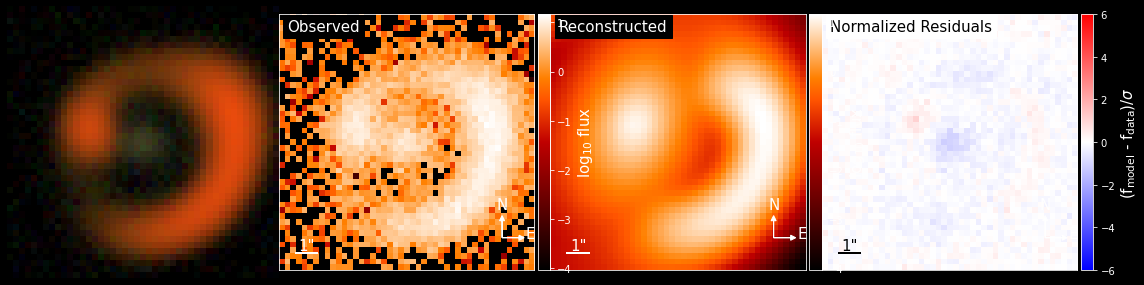

3.453117108179766
{'kwargs_lens': [{'theta_E': 6.286400036482751, 'e1': 0.12187494826539802, 'e2': 0.155303874290202, 'center_x': -1.3336676185724752, 'center_y': 0.056479362434844235}, {'gamma1': 0.18215015359231665, 'gamma2': 0.040734357993970176, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1400.4176091969114, 'R_sersic': 1.068040537545986, 'n_sersic': 0.8509870251090328, 'e1': -0.3281049362789051, 'e2': 0.20683692779736676, 'center_x': -2.6552294357897446, 'center_y': 0.4806042317780797}], 'kwargs_lens_light': [{'amp': 521.0197182742995, 'R_sersic': 1.5542188690543992, 'n_sersic': 1.250970963129864, 'e1': -0.1626756773164986, 'e2': 0.12183766138739727, 'center_x': -1.9951664535030331, 'center_y': 0.8018880207475961}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


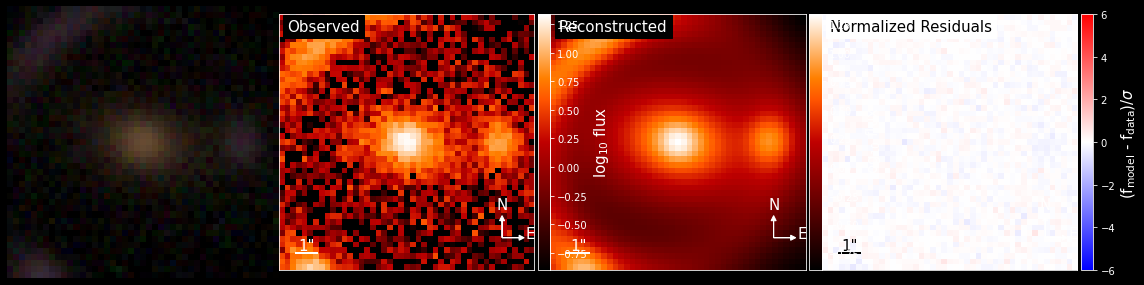

5.988401941297126
{'kwargs_lens': [{'theta_E': 6.053590085425032, 'e1': 0.36303124030151723, 'e2': 0.12502307971995352, 'center_x': -0.31683735258693035, 'center_y': -0.20057552338347734}, {'gamma1': 0.0780497403284919, 'gamma2': 0.1032784701553596, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 31.368077503023112, 'R_sersic': 0.8606659926017121, 'n_sersic': 1.7061639254669987, 'e1': -0.0733866449086866, 'e2': -0.02546267219019538, 'center_x': -1.162920192450299, 'center_y': -0.22110644242328353}], 'kwargs_lens_light': [{'amp': 31.85422181660968, 'R_sersic': 3.523769980917929, 'n_sersic': 3.2310380095843123, 'e1': 0.20021394933759892, 'e2': -0.07234127298232808, 'center_x': -0.00473976004031515, 'center_y': 0.023572642956277028}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


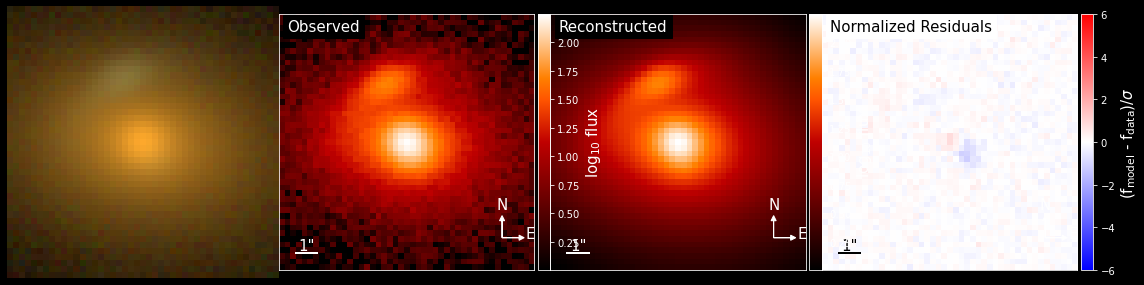

1.8535776089099032
{'kwargs_lens': [{'theta_E': 1.7802253167334006, 'e1': 0.10036802364252026, 'e2': -0.25659496923106345, 'center_x': -0.03215273109738706, 'center_y': -0.4187554475495596}, {'gamma1': -0.08162839138324796, 'gamma2': -0.06891975010990388, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 211.4986789513055, 'R_sersic': 1.3912648802411374, 'n_sersic': 4.2277149171439685, 'e1': 0.3120587978705884, 'e2': 0.42834242599344197, 'center_x': -0.6354871962416455, 'center_y': 0.7355744367566687}], 'kwargs_lens_light': [{'amp': 693.5995894382794, 'R_sersic': 3.8302254051608133, 'n_sersic': 3.0465211209360423, 'e1': 0.16328002068106448, 'e2': -0.05884505381384132, 'center_x': 0.01644609485168875, 'center_y': -0.014398636843560159}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


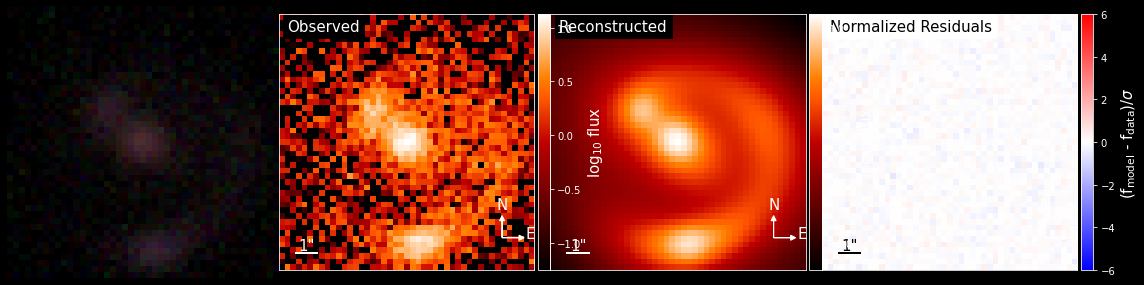

3.568870786017589
{'kwargs_lens': [{'theta_E': 3.7054934881526624, 'e1': 0.26452446787155176, 'e2': -0.16282829708022578, 'center_x': -0.050174079164620244, 'center_y': 0.15403252502304077}, {'gamma1': 0.04538483532721424, 'gamma2': 0.023131637718601175, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 28.371165361681285, 'R_sersic': 0.9546745890767929, 'n_sersic': 2.562451233782989, 'e1': 0.15197108960659977, 'e2': 0.045477901375300556, 'center_x': 0.6212079017225323, 'center_y': -1.02012687656481}], 'kwargs_lens_light': [{'amp': 10.479637754470879, 'R_sersic': 4.078171046285972, 'n_sersic': 4.356298844445152, 'e1': 0.06995865198415746, 'e2': -0.2328700069216545, 'center_x': -0.05899242090717258, 'center_y': 0.062346579925982075}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


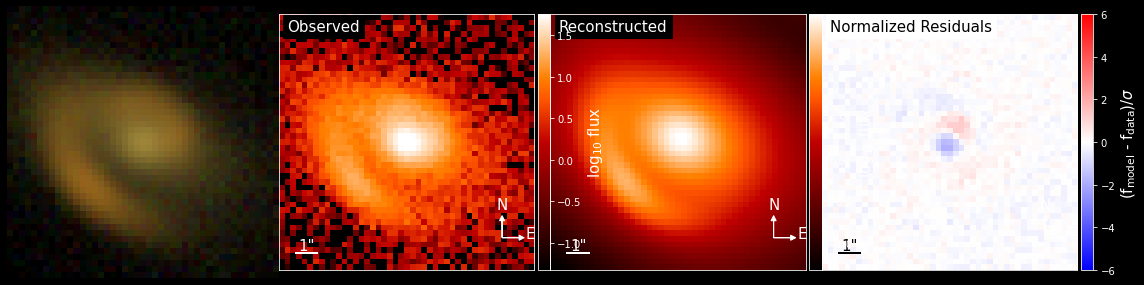

2.190460882184422
{'kwargs_lens': [{'theta_E': 7.354014917474538, 'e1': 0.11838587567828128, 'e2': -0.22070843194601583, 'center_x': 1.9247905660036042, 'center_y': 0.39329250783352343}, {'gamma1': 0.191207182228401, 'gamma2': -0.1966097639002436, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 292.97361746488207, 'R_sersic': 1.782281800502046, 'n_sersic': 2.761808747879673, 'e1': -0.26062770745774466, 'e2': -0.49405350750206145, 'center_x': 3.8183163616452624, 'center_y': 1.6981921142395096}], 'kwargs_lens_light': [{'amp': 512.9051488512329, 'R_sersic': 2.004655179657143, 'n_sersic': 1.5518157346371415, 'e1': 0.12871938343492473, 'e2': -0.11703624465247428, 'center_x': 0.14860465058345657, 'center_y': 0.17268961389405546}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


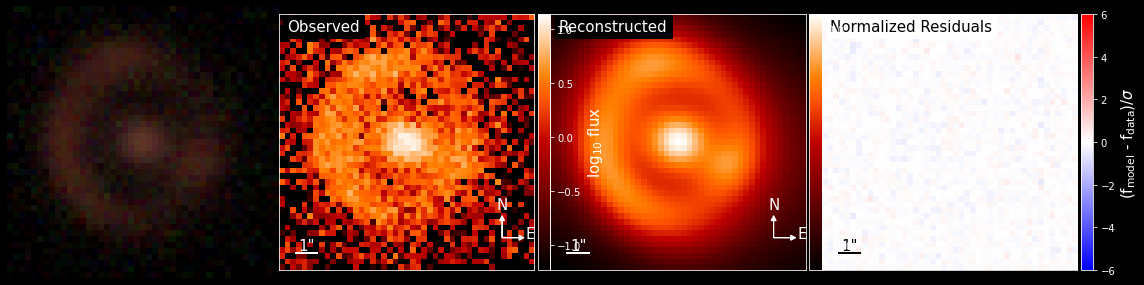

3.3104898116568453
{'kwargs_lens': [{'theta_E': 3.316020021296132, 'e1': 0.20860783734452035, 'e2': -0.12582544436039297, 'center_x': 0.04742729245460295, 'center_y': -0.07227349113213033}, {'gamma1': 0.01248156619482237, 'gamma2': -0.024006664973602203, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 69.44569274097096, 'R_sersic': 0.9630217121070932, 'n_sersic': 0.9190558943497145, 'e1': -0.05688244429096587, 'e2': -0.16460248443087586, 'center_x': -0.45452589161886015, 'center_y': 0.3090276464468979}], 'kwargs_lens_light': [{'amp': 15.108586889824107, 'R_sersic': 3.8714250511040853, 'n_sersic': 4.246506826718321, 'e1': 0.15091428585614144, 'e2': -0.05474666413003049, 'center_x': 0.025156611695965697, 'center_y': 0.04333710031028949}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


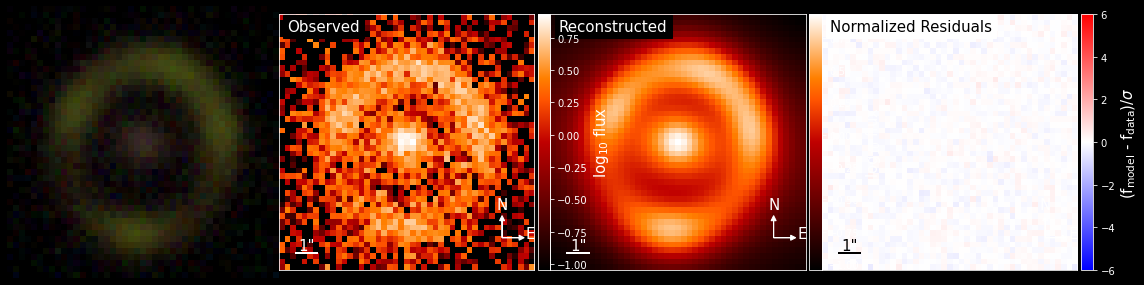

3.5975652674962957
{'kwargs_lens': [{'theta_E': 3.6610765414147943, 'e1': 0.21630179809388184, 'e2': -0.07875317935052463, 'center_x': -0.038035479176603604, 'center_y': 0.0484303387316819}, {'gamma1': 0.02596013609898854, 'gamma2': -0.009399874437823122, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 81.56881551585258, 'R_sersic': 0.6524121467957591, 'n_sersic': 1.1690144793112374, 'e1': -0.078673113991442, 'e2': 0.03941651280534375, 'center_x': 0.017594707880775634, 'center_y': -0.2762700486827231}], 'kwargs_lens_light': [{'amp': 2.4190824115822425, 'R_sersic': 9.574997842089989, 'n_sersic': 4.199723492768275, 'e1': 0.18142220946086707, 'e2': -0.05986689776005524, 'center_x': -0.012661599204818269, 'center_y': -0.011768620006922845}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


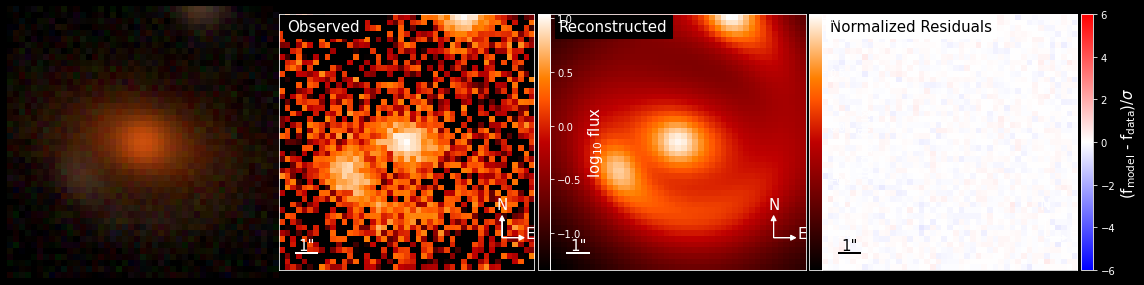

4.537791915376632
{'kwargs_lens': [{'theta_E': 4.481481105971777, 'e1': 0.24038915893356194, 'e2': -0.06694995104045484, 'center_x': -0.052845719104523764, 'center_y': 0.10333850863105606}, {'gamma1': 0.01297568180674176, 'gamma2': 0.01782583461479889, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 11.274862138907217, 'R_sersic': 1.4882566938903556, 'n_sersic': 4.6455743543806305, 'e1': -0.09369238016789797, 'e2': -0.06747038347154713, 'center_x': 0.758336207119895, 'center_y': 1.3381901142006758}], 'kwargs_lens_light': [{'amp': 134.19522436866743, 'R_sersic': 3.103269806214246, 'n_sersic': 2.9512849436521043, 'e1': 0.2070258180057246, 'e2': -0.11005151599422486, 'center_x': 0.005331537154257902, 'center_y': 0.008619406431136747}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


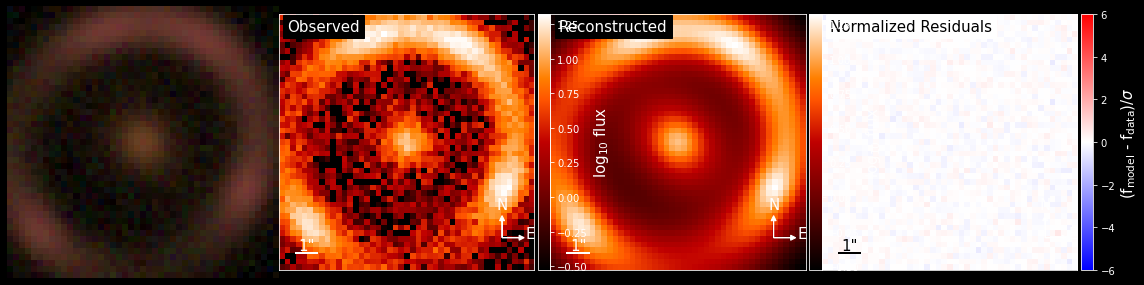

5.3777682681874905
{'kwargs_lens': [{'theta_E': 5.391832841210856, 'e1': 0.0009836992578379812, 'e2': -0.16452954742999026, 'center_x': 0.06265388686651846, 'center_y': 0.01704778446378142}, {'gamma1': -0.0017336398865497238, 'gamma2': -0.012361598284794755, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 75.85046266458433, 'R_sersic': 1.0854925807978313, 'n_sersic': 2.281296952559754, 'e1': -0.041464262179331815, 'e2': 0.03439898225515073, 'center_x': -0.3269195987607079, 'center_y': -0.18928278937983112}], 'kwargs_lens_light': [{'amp': 20.727840706264725, 'R_sersic': 4.141054886959829, 'n_sersic': 3.3437458848482793, 'e1': 3.240613373339807e-05, 'e2': -0.1399361352388279, 'center_x': -0.01877483412966064, 'center_y': 0.019041818739586824}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


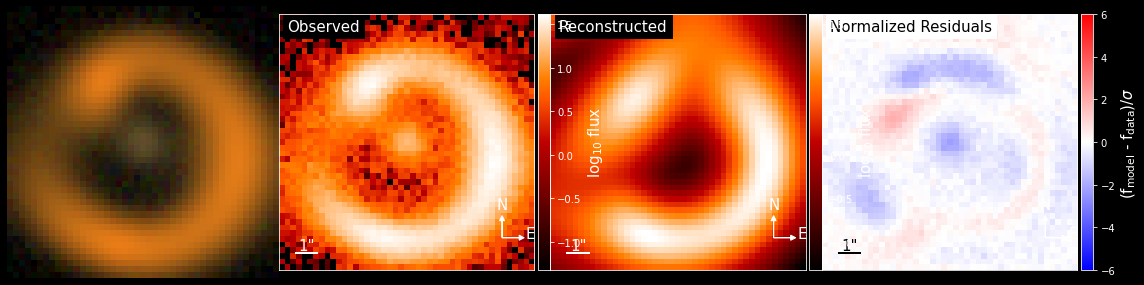

4.015482230196383
{'kwargs_lens': [{'theta_E': 5.813490925719082, 'e1': 0.19054086507944942, 'e2': -0.11850091375566218, 'center_x': -1.6733257252256701, 'center_y': 0.19371115993226903}, {'gamma1': 0.16754663728261093, 'gamma2': -0.199985181967231, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1729.1359382177386, 'R_sersic': 1.1627912438716523, 'n_sersic': 1.120482767992541, 'e1': -0.14128633040495575, 'e2': 0.3252461578396393, 'center_x': -1.8916944259415962, 'center_y': 0.7378570535859622}], 'kwargs_lens_light': [{'amp': 1329.3202720351767, 'R_sersic': 2.3455073544063874, 'n_sersic': 0.9591478657638774, 'e1': -0.036129092703790604, 'e2': 0.4438291175856004, 'center_x': -1.9952954917198653, 'center_y': 1.999833582968523}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


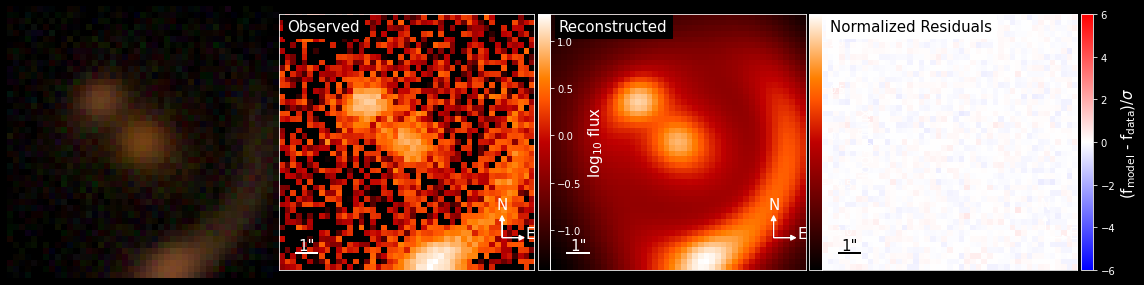

4.301036128868993
{'kwargs_lens': [{'theta_E': 4.319522898881179, 'e1': 0.10949897294236798, 'e2': -0.11526527116866955, 'center_x': -0.030214554996753712, 'center_y': 0.039216561467240556}, {'gamma1': 0.021337716300601092, 'gamma2': 0.02433462375156782, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 212.9838660951404, 'R_sersic': 0.6384361035946511, 'n_sersic': 2.4548148049769787, 'e1': -0.2672210760435857, 'e2': 0.06577117522366359, 'center_x': 0.7914351791422283, 'center_y': -1.2511575361669354}], 'kwargs_lens_light': [{'amp': 26.110498250616534, 'R_sersic': 3.5471454740337824, 'n_sersic': 3.451411641997332, 'e1': 0.07171747635539659, 'e2': -0.12615622028486295, 'center_x': 0.031590995970262235, 'center_y': -0.01901149164390045}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


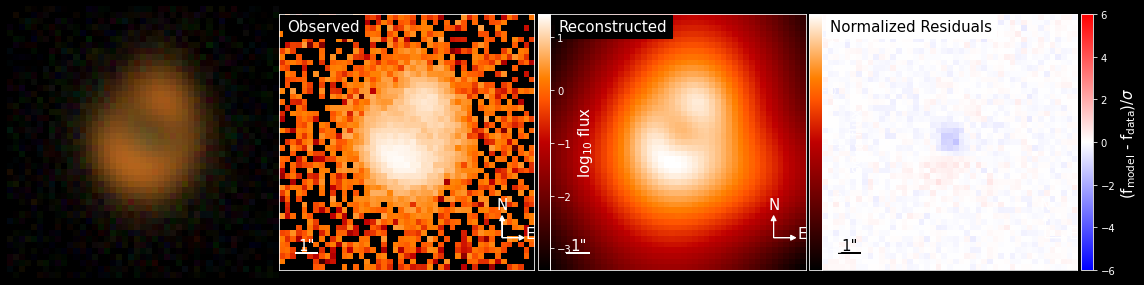

1.525531774784514
{'kwargs_lens': [{'theta_E': 1.3527442786347532, 'e1': -0.022096789118830736, 'e2': -0.2935159974695608, 'center_x': -0.0856808949945164, 'center_y': -0.025000198908368066}, {'gamma1': -0.11228597742023139, 'gamma2': 0.03481373995330414, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 449.6714684449558, 'R_sersic': 0.9035526236143532, 'n_sersic': 1.2824331050760822, 'e1': -0.06163970943723737, 'e2': -0.0012738323397167295, 'center_x': 0.15939756892715468, 'center_y': 0.3858751283854382}], 'kwargs_lens_light': [{'amp': 149.63016217681997, 'R_sersic': 1.6584230789828598, 'n_sersic': 0.717005346537488, 'e1': 0.2342557893651257, 'e2': -0.03710253399760888, 'center_x': 0.5161644838848991, 'center_y': -1.0450736003194636}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


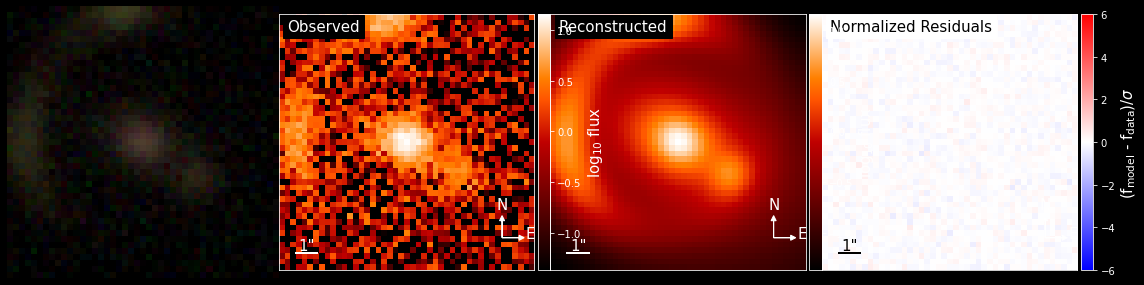

4.577483133990286
{'kwargs_lens': [{'theta_E': 4.5192715040213995, 'e1': 0.16488808202815117, 'e2': -0.17895727822758967, 'center_x': -0.13776331582131685, 'center_y': 0.17565643625755023}, {'gamma1': 0.0070547376123777095, 'gamma2': 0.011970970552257834, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 52.94015673632035, 'R_sersic': 0.5690831486660527, 'n_sersic': 1.4595075792964265, 'e1': 0.08004022530679972, 'e2': -0.05396110078557753, 'center_x': -0.9422232289373729, 'center_y': 0.9827659843582432}], 'kwargs_lens_light': [{'amp': 12.385587417667601, 'R_sersic': 3.68536602622038, 'n_sersic': 4.652181999314225, 'e1': 0.1160041505447697, 'e2': -0.16189536659123513, 'center_x': 0.03145184480033683, 'center_y': 0.06022288423766363}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


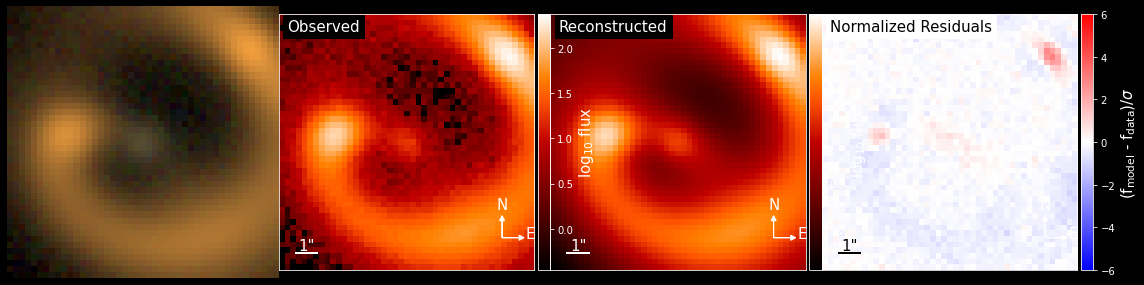

4.941382936856592
{'kwargs_lens': [{'theta_E': 4.958337813384863, 'e1': 0.2027541862867186, 'e2': -0.18901144464441308, 'center_x': -0.1295746231741576, 'center_y': -0.004438494074379849}, {'gamma1': 0.01270040864936458, 'gamma2': -0.014838037808235765, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1988.3448572135717, 'R_sersic': 1.1388857324438055, 'n_sersic': 2.475513066433247, 'e1': -0.011663904940609635, 'e2': -0.24417788013257624, 'center_x': 1.2223852692897386, 'center_y': 0.3387974755911306}], 'kwargs_lens_light': [{'amp': 7.247969987747461, 'R_sersic': 9.899420530587012, 'n_sersic': 4.658320155943938, 'e1': 0.21811200227500824, 'e2': -0.48894626783707856, 'center_x': -0.04848784420015812, 'center_y': 0.05194384721002555}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


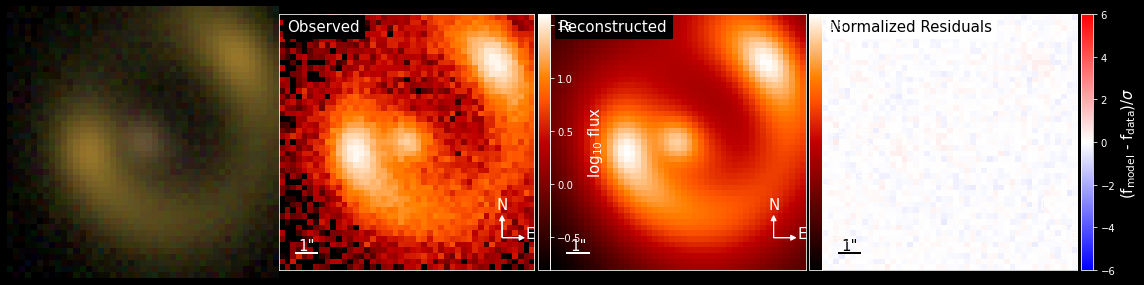

3.8471905799812474
{'kwargs_lens': [{'theta_E': 3.842266356233161, 'e1': 0.10434096252737075, 'e2': -0.24086101718266148, 'center_x': -0.090555409146413, 'center_y': -0.024107727264310576}, {'gamma1': 0.011398940383353671, 'gamma2': -0.005510115277898989, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 368.75397988605386, 'R_sersic': 1.3007552154686488, 'n_sersic': 1.7551410973272357, 'e1': -0.13946572477010283, 'e2': -0.045430385700538756, 'center_x': 1.2487435115241965, 'center_y': 0.8554422435565993}], 'kwargs_lens_light': [{'amp': 15.038180730911288, 'R_sersic': 5.737817429737434, 'n_sersic': 3.972843270193728, 'e1': 0.0876284536967527, 'e2': -0.22315223977015783, 'center_x': -0.034268950423642204, 'center_y': 0.018224803422375604}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


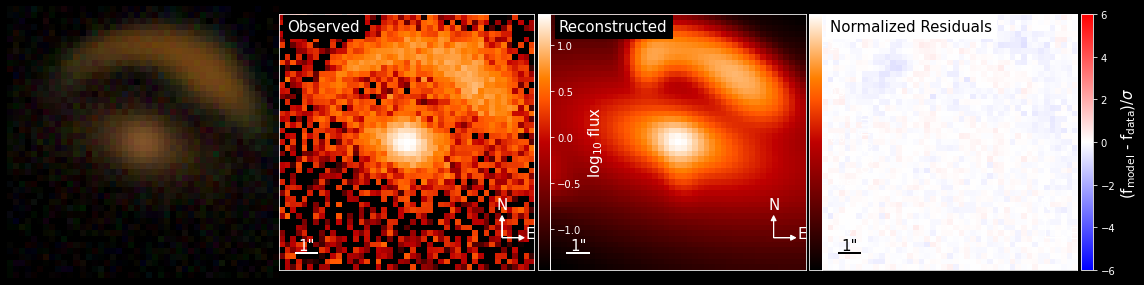

5.988154254408185
{'kwargs_lens': [{'theta_E': 4.603435054697107, 'e1': -0.4975575219476791, 'e2': -0.4771415175619456, 'center_x': -0.9392676956903193, 'center_y': 0.970852991452466}, {'gamma1': 0.19347223064813066, 'gamma2': 0.03209268957914942, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 366.16883985643494, 'R_sersic': 1.1569042852416034, 'n_sersic': 0.5175925274162305, 'e1': 0.07579045193220996, 'e2': -0.3214984674820083, 'center_x': -2.2275981851438362, 'center_y': 1.5908043479342615}], 'kwargs_lens_light': [{'amp': 50.07822744822399, 'R_sersic': 3.964304298243442, 'n_sersic': 3.7673951592548, 'e1': 0.37383808932793383, 'e2': -0.2098325876429087, 'center_x': 0.03051058835761268, 'center_y': 0.06645474377662672}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


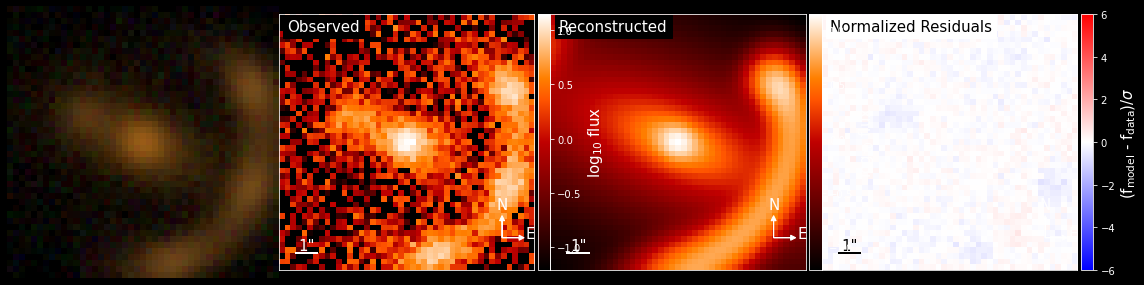

4.606553648373386
{'kwargs_lens': [{'theta_E': 6.8563159061992796, 'e1': -0.1647500993777416, 'e2': 0.4901066464713897, 'center_x': 0.39079239824795475, 'center_y': -0.16608854227839176}, {'gamma1': -0.02782302117501905, 'gamma2': 0.16541204920410657, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 295.6269983548974, 'R_sersic': 0.6159785895379446, 'n_sersic': 1.0014620933738976, 'e1': -0.13246196854566483, 'e2': -0.0810492748746382, 'center_x': -1.334275722245398, 'center_y': 0.41202513671504976}], 'kwargs_lens_light': [{'amp': 20.77999038450255, 'R_sersic': 9.86169828251253, 'n_sersic': 4.320694366068168, 'e1': 0.3282971588864692, 'e2': -0.30741537630493915, 'center_x': -0.03951985234949837, 'center_y': 0.008692044934941317}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


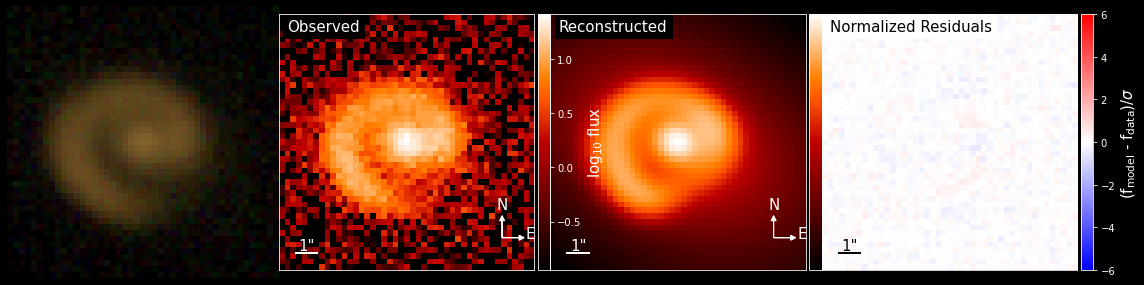

2.3348203730402677
{'kwargs_lens': [{'theta_E': 2.3460256990339614, 'e1': -0.26147723601287076, 'e2': 0.01156250298990269, 'center_x': -1.0938311712058606, 'center_y': -0.6231721184602821}, {'gamma1': -0.08176380117078443, 'gamma2': 0.04974340905504679, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 352.43852794738757, 'R_sersic': 0.6751937098158826, 'n_sersic': 0.5048671880504899, 'e1': 0.27292817691247306, 'e2': -0.07676189020942428, 'center_x': -0.6832321822787814, 'center_y': -0.22607105949240147}], 'kwargs_lens_light': [{'amp': 25.694366635341865, 'R_sersic': 5.31413484996009, 'n_sersic': 4.4059839076301, 'e1': 0.12998972577873824, 'e2': -0.1594625937311917, 'center_x': -0.045864799495807886, 'center_y': -0.006435962605003653}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


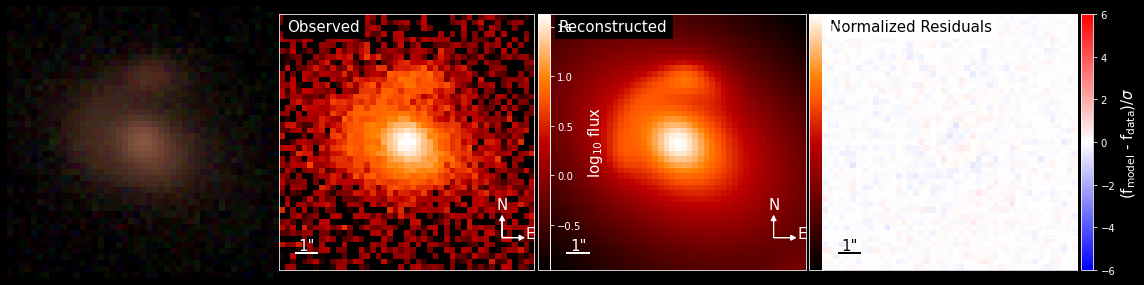

2.1432560622519947
{'kwargs_lens': [{'theta_E': 4.554949416786874, 'e1': -0.10638189273443202, 'e2': 0.2681510891334835, 'center_x': 0.48548250044484254, 'center_y': -0.9867080221689706}, {'gamma1': -0.17848207423163634, 'gamma2': -0.05861971154184395, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 33.38898473613336, 'R_sersic': 0.8947979715149814, 'n_sersic': 2.0774628773989217, 'e1': 0.2867922205340841, 'e2': 0.2769829485566768, 'center_x': 1.5948093348823271, 'center_y': -1.9056073129150828}], 'kwargs_lens_light': [{'amp': 103.81111236615584, 'R_sersic': 2.7732122517670637, 'n_sersic': 2.9240807229348804, 'e1': 0.08217722735812616, 'e2': -0.16591188664048845, 'center_x': 0.02583949649120952, 'center_y': -0.07642054798618625}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


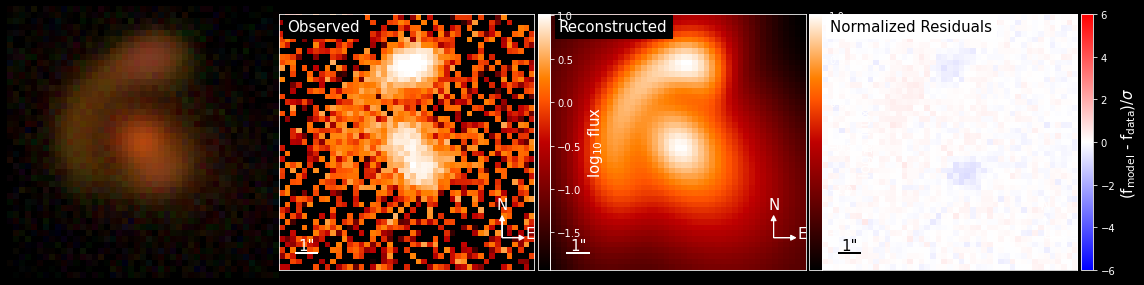

2.5459746276468325
{'kwargs_lens': [{'theta_E': 6.861548662731447, 'e1': -0.28434008951764245, 'e2': 0.3473889136691215, 'center_x': 1.187015177617668, 'center_y': -0.46986186384008743}, {'gamma1': -0.09947934043703575, 'gamma2': 0.049939669216750165, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 197.9903584300242, 'R_sersic': 1.1078963574315415, 'n_sersic': 1.7276033232618568, 'e1': -0.140289710275103, 'e2': 0.3411994501832689, 'center_x': 3.3621596256082693, 'center_y': -2.531221051436949}], 'kwargs_lens_light': [{'amp': 269.9494639370097, 'R_sersic': 1.9695210835900503, 'n_sersic': 1.686957942526569, 'e1': -0.033062109394504956, 'e2': -0.2082527542098748, 'center_x': 0.12209741197829847, 'center_y': -0.23072443166009604}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


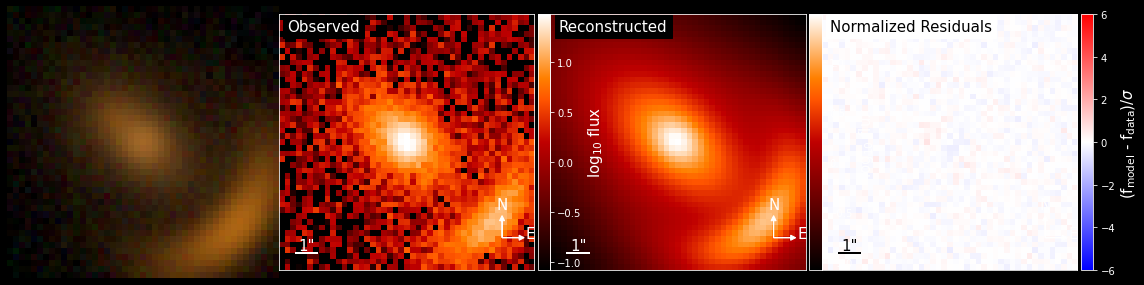

3.772438896007374
{'kwargs_lens': [{'theta_E': 3.052278975600545, 'e1': -0.0330920959720488, 'e2': -0.144256787785154, 'center_x': 0.7841386498162688, 'center_y': -0.480762806435049}, {'gamma1': -0.048196099049546304, 'gamma2': 0.13460075126281967, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 190.05109987657235, 'R_sersic': 1.1791321467703464, 'n_sersic': 2.6656813732107922, 'e1': 0.0864603594449053, 'e2': -0.19512490651973324, 'center_x': 2.628141784527363, 'center_y': -2.089873738930184}], 'kwargs_lens_light': [{'amp': 111.53924201198419, 'R_sersic': 3.6803052886692984, 'n_sersic': 3.037223194146651, 'e1': 0.04303719341513904, 'e2': -0.3093313302576121, 'center_x': -0.10988531836964179, 'center_y': 0.06271325586822282}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


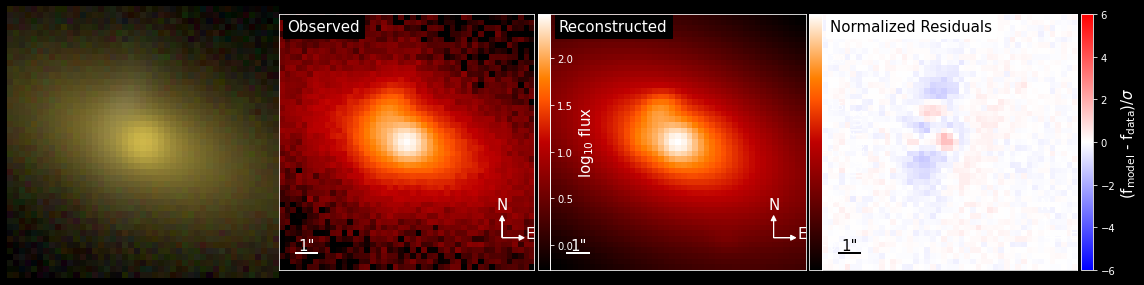

1.0197793809771918
{'kwargs_lens': [{'theta_E': 2.8186235086436544, 'e1': 0.24330848220055346, 'e2': -0.04286199273962048, 'center_x': 0.7822453471918905, 'center_y': -0.6858392064082814}, {'gamma1': 0.0002508842542596826, 'gamma2': -0.16424798796036572, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 2264576.641821219, 'R_sersic': 0.009952851155833583, 'n_sersic': 2.7564991580527938, 'e1': 0.3110426142838033, 'e2': -0.14314013164892073, 'center_x': 0.7262585269703318, 'center_y': -1.1747624433646777}], 'kwargs_lens_light': [{'amp': 719.8052395139514, 'R_sersic': 3.188404820036683, 'n_sersic': 3.0962774631388514, 'e1': 0.21347612265683677, 'e2': -0.19682657971739095, 'center_x': -0.027648604929420253, 'center_y': 0.009654901722074815}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


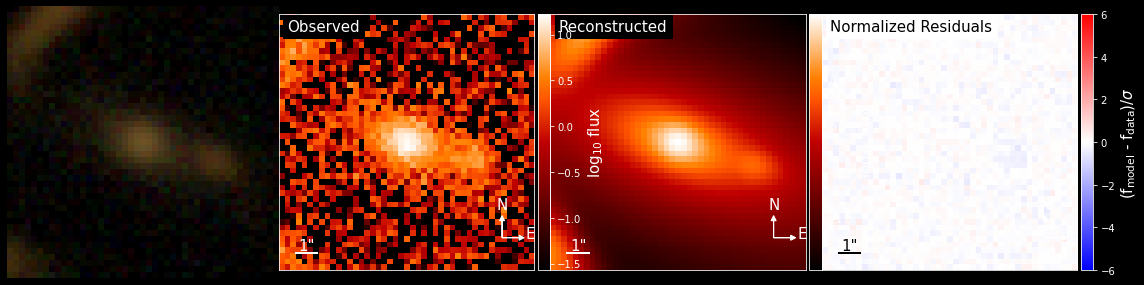

6.2578757969342425
{'kwargs_lens': [{'theta_E': 6.636170684435943, 'e1': 0.27995652328325277, 'e2': -0.3602867675700191, 'center_x': 1.5937623629389406, 'center_y': -0.4429113265558884}, {'gamma1': -0.0385682515007193, 'gamma2': -0.014397634289577459, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 144.04312762108887, 'R_sersic': 0.6333881548707756, 'n_sersic': 1.0274515466579301, 'e1': 0.08466076844997786, 'e2': -0.05482811182414568, 'center_x': -1.5847931109950033, 'center_y': -0.0016323849365173504}], 'kwargs_lens_light': [{'amp': 28.540671217337632, 'R_sersic': 4.514456045943232, 'n_sersic': 3.882763982010231, 'e1': 0.3402384420646217, 'e2': -0.2762061995123932, 'center_x': 0.016846182664657053, 'center_y': -0.028446015218987007}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


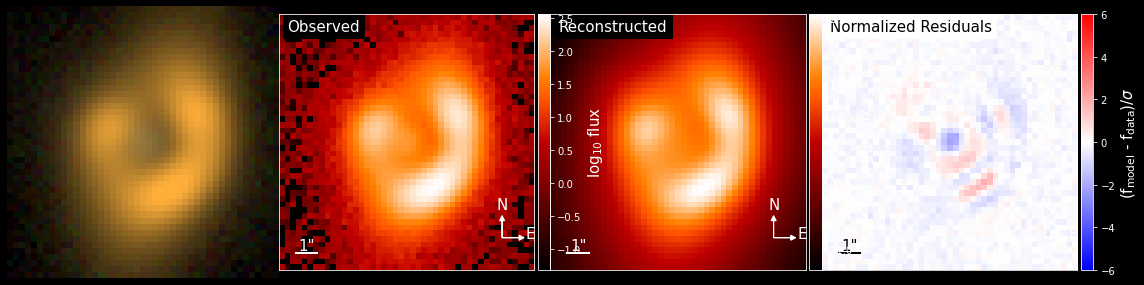

2.2615704825422953
{'kwargs_lens': [{'theta_E': 2.3073936470032783, 'e1': 0.17586291309396326, 'e2': -0.3019640559448203, 'center_x': -0.10801333105866211, 'center_y': 0.0234308652596856}, {'gamma1': 0.013389208715347881, 'gamma2': -0.03242707458518401, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 2822.5985537574143, 'R_sersic': 1.1217536557566417, 'n_sersic': 2.453335538312762, 'e1': -0.28199535732876346, 'e2': 0.12441891793102017, 'center_x': 0.45083745409816106, 'center_y': -0.08651332259959184}], 'kwargs_lens_light': [{'amp': 654.8886353351854, 'R_sersic': 1.73681140602176, 'n_sersic': 0.5028281577056539, 'e1': -0.01360721643502462, 'e2': -0.2889937507061163, 'center_x': -0.13353298016085272, 'center_y': -0.013313453768366873}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


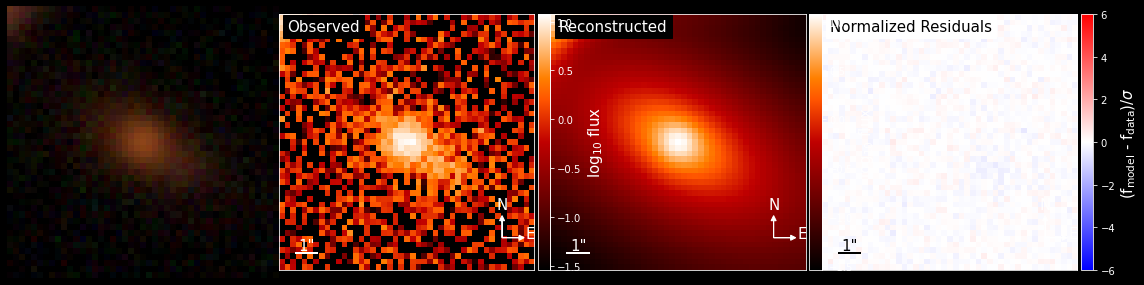

5.75204583699836
{'kwargs_lens': [{'theta_E': 5.003062695116761, 'e1': 0.014870419287799294, 'e2': -0.48525340880347767, 'center_x': -0.7280245715082475, 'center_y': 0.05403911407476108}, {'gamma1': 0.08167729896790145, 'gamma2': 0.08055422907622961, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 375.7476667984827, 'R_sersic': 2.540140321185072, 'n_sersic': 1.2573534031288252, 'e1': 0.37580553096668734, 'e2': 0.47661821792752, 'center_x': -2.1601097113184977, 'center_y': 4.613016414983967}], 'kwargs_lens_light': [{'amp': 38.9020322984032, 'R_sersic': 4.2095996449485895, 'n_sersic': 3.50193893040636, 'e1': 0.1599477080318098, 'e2': -0.2709114017449059, 'center_x': 0.03897240274269145, 'center_y': -0.010126848420996717}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


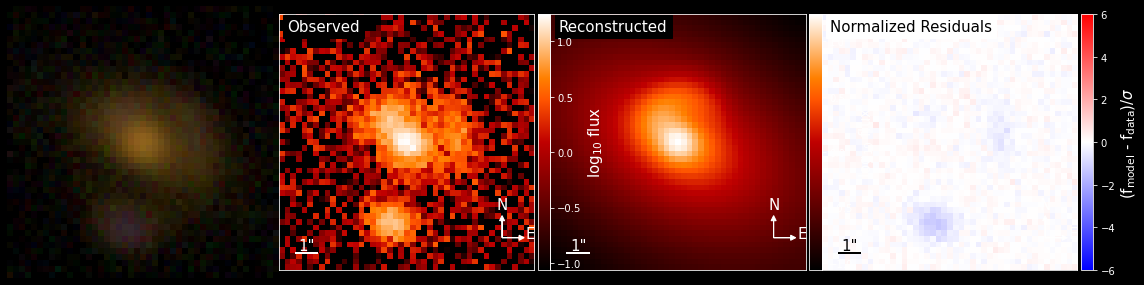

2.655745081710064
{'kwargs_lens': [{'theta_E': 6.522454388554476, 'e1': 0.49633945511102834, 'e2': -0.09814396708964071, 'center_x': 1.9878569855996076, 'center_y': 0.12129157049818681}, {'gamma1': 0.17891514355684676, 'gamma2': -0.05434447825414429, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 53.99610335803711, 'R_sersic': 2.9921163469094054, 'n_sersic': 0.7021261420109287, 'e1': -0.4981875492682233, 'e2': 0.49845125908898974, 'center_x': 3.7161091510780153, 'center_y': -1.6106245501706549}], 'kwargs_lens_light': [{'amp': 25.94818137523957, 'R_sersic': 6.344354218607863, 'n_sersic': 3.85645616271258, 'e1': 0.13279771052944606, 'e2': -0.19297521644116367, 'center_x': 0.019294803410629065, 'center_y': -0.001844018045214696}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


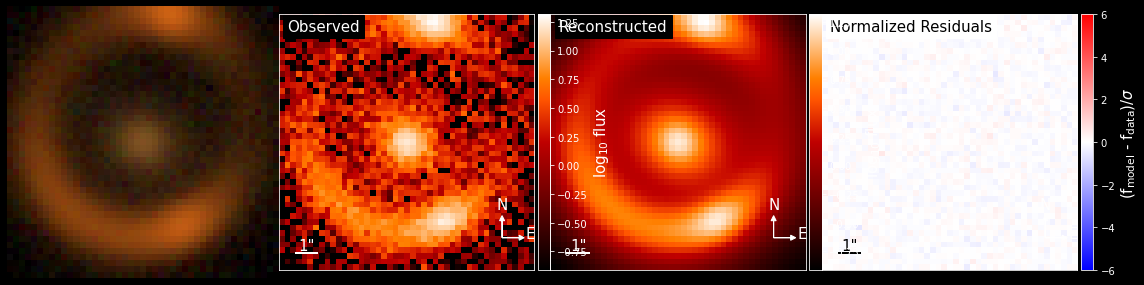

4.774915365975624
{'kwargs_lens': [{'theta_E': 4.7658154549396725, 'e1': 0.10153591016445665, 'e2': -0.11675176599811143, 'center_x': 0.03278255404688244, 'center_y': -0.1518659012588272}, {'gamma1': 0.004131394448910287, 'gamma2': -0.009122841434348865, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 316.83482609919236, 'R_sersic': 0.8363880518401702, 'n_sersic': 3.02784839462125, 'e1': -0.029995864998365544, 'e2': 0.06629375275681634, 'center_x': 0.06608006424175492, 'center_y': 0.7645601751929076}], 'kwargs_lens_light': [{'amp': 52.25184531884055, 'R_sersic': 3.015426244119866, 'n_sersic': 2.933634345204744, 'e1': 0.08767049913427366, 'e2': -0.08940278937931434, 'center_x': 0.017796222625730877, 'center_y': -0.0085260618720477}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


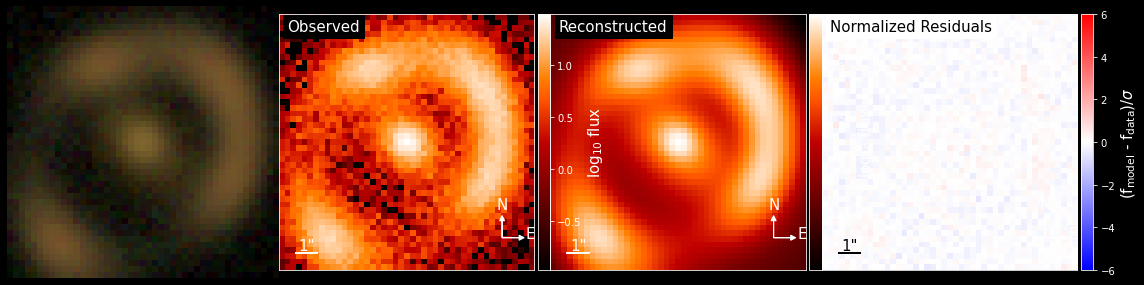

4.717260564071193
{'kwargs_lens': [{'theta_E': 4.767168808821434, 'e1': 0.006680011989002537, 'e2': -0.33278850072188465, 'center_x': 0.014062981769292333, 'center_y': 0.03933251826366644}, {'gamma1': -0.00016463135052913452, 'gamma2': -0.01330194009282517, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 344.5862661153369, 'R_sersic': 0.8979926041050309, 'n_sersic': 0.7998575318425516, 'e1': -0.13569564389311167, 'e2': 0.09711064196532264, 'center_x': -0.35846620740369745, 'center_y': -0.6336367709076176}], 'kwargs_lens_light': [{'amp': 36.44954465166411, 'R_sersic': 4.9187540619812165, 'n_sersic': 3.744860360925306, 'e1': 0.02844716203884873, 'e2': -0.281768049691459, 'center_x': 0.02509215363288414, 'center_y': -0.015852197542625235}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


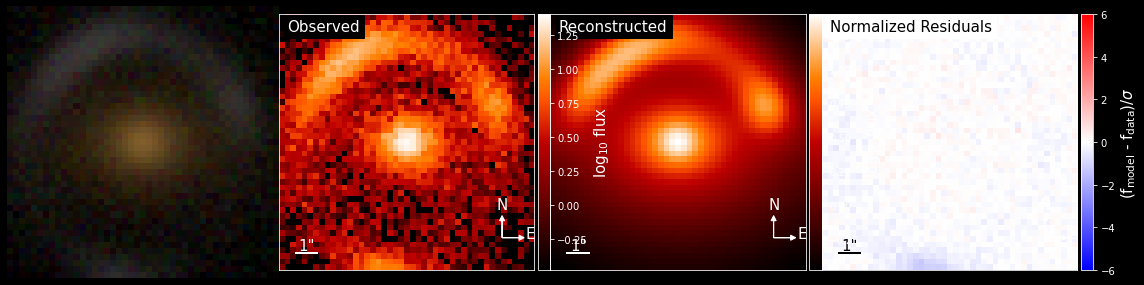

5.151546860940139
{'kwargs_lens': [{'theta_E': 7.845662065201532, 'e1': 0.15564071323966056, 'e2': 0.05549984606927115, 'center_x': -0.1503308554739674, 'center_y': -1.9916712551824605}, {'gamma1': -0.19509363862830978, 'gamma2': 0.03391659175726762, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 41.027811979010615, 'R_sersic': 0.8578383504495826, 'n_sersic': 1.5943900112502882, 'e1': 0.1559962439893082, 'e2': 0.03735511867023981, 'center_x': -0.4166997354840551, 'center_y': -4.390976534117538}], 'kwargs_lens_light': [{'amp': 13.505353004401334, 'R_sersic': 9.928662232037128, 'n_sersic': 4.244007169649598, 'e1': 0.1788488411045701, 'e2': -0.005346181764590327, 'center_x': -0.016370481667782433, 'center_y': 0.021514385010196077}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


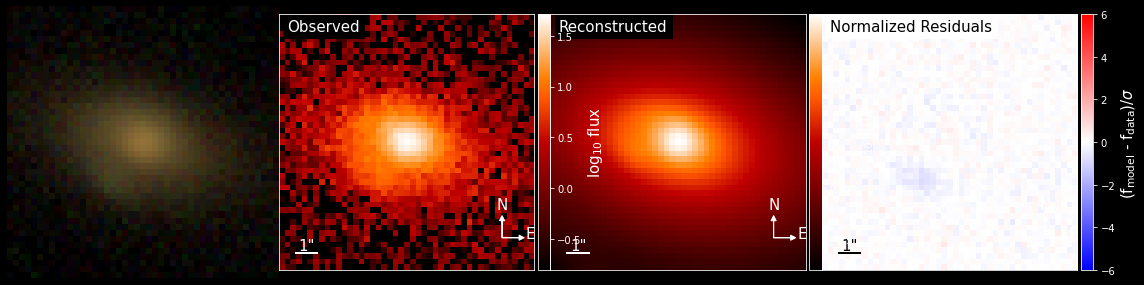

1.5027837871961838
{'kwargs_lens': [{'theta_E': 3.7599152399909137, 'e1': 0.4865337359589927, 'e2': -0.1892055927434424, 'center_x': -0.5534147237794751, 'center_y': -1.4954024080130608}, {'gamma1': -0.18565041788370987, 'gamma2': -0.14459611618061613, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 39.474090541410916, 'R_sersic': 1.098733831002439, 'n_sersic': 4.752685361240205, 'e1': 0.4570949473959277, 'e2': -0.48553627385439124, 'center_x': -0.5472706586082008, 'center_y': -3.440334926605856}], 'kwargs_lens_light': [{'amp': 131.38116071699392, 'R_sersic': 3.279983804345842, 'n_sersic': 2.4280778112626784, 'e1': 0.21504399683008155, 'e2': -0.1080842853497708, 'center_x': 0.0007506173272266042, 'center_y': -0.0009315412693915665}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [9]:
for i in range(len(results)):
    plot_modeling(images[i], plots[i])
    data_image = data.iloc[i]
    print(data_image['Einstein_rad'])
    print(results[i])